In [1]:
import joblib
import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import copy

In [2]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

In [4]:
import os
os.chdir('./../../')
from Resources.APIKeys import APIKeys

In [5]:
ohlc_intraday = {}
api_call_count = 1
ts = TimeSeries(key=APIKeys.alpha_vantage, output_format='pandas')

In [6]:
try:
    ohlc_intraday = joblib.load('del_ohlc_intraday.joblib')
except:
    for ticker in tickers:
        data = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')[0]
        api_call_count += 1
        data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        data = data[::-1]
        data = data.between_time('09:35', '16:00') # Some priviledged folks are allowed to trade outside trading hours
        ohlc_intraday[ticker] = data
        if api_call_count == 5:
            api_call_count = 1
            time.sleep(60 - ((time.time() - start_time) % 60.0))
    joblib.dump(ohlc_intraday, 'del_ohlc_intraday.joblib')
tickers = ohlc_intraday.keys()

In [7]:
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  MSFT


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  AAPL


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  FB


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  AMZN


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  INTC


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  CSCO


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  VZ


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  IBM


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  TSLA


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

merging for  AMD


/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py37_default/lib/python

In [8]:
ohlc_renko[ticker]

,Open,High,Low,Close,Volume,TR,ATR,roll_max_cp,roll_min_cp,roll_max_vol,ret,Date,bar_num,obv,obv_slope
0,93.670,93.7998,93.6300,93.76,217157.0,0.1698,0.255200,94.22,93.230,1104033.0,0.000000,2021-02-12 12:50:00,1.0,0.0,0.000000
1,93.765,93.7800,93.4150,93.42,403068.0,0.3650,0.261700,94.22,93.230,1104033.0,0.000000,2021-02-12 12:55:00,1.0,-403068.0,0.000000
2,93.420,93.6600,93.3900,93.63,287031.0,0.2700,0.264135,94.22,93.230,1104033.0,0.000000,2021-02-12 13:00:00,1.0,-116037.0,0.000000
3,93.630,93.8301,93.5801,93.75,270161.0,0.2500,0.256135,94.22,93.230,1104033.0,0.000000,2021-02-12 13:05:00,1.0,154124.0,0.000000
4,93.750,93.8080,93.5400,93.60,210059.0,0.2680,0.262035,94.22,93.230,1104033.0,0.000000,2021-02-12 13:10:00,1.0,-55935.0,17.728567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,81.010,81.1900,80.9706,81.13,402398.0,0.2194,0.164765,81.19,80.645,402398.0,-0.001479,2021-03-12 15:40:00,1.0,-28071278.0,38.691916
1517,81.120,81.1200,80.9100,80.99,453937.0,0.2200,0.166765,81.19,80.645,453937.0,0.001729,2021-03-12 15:45:00,1.0,-28525215.0,18.563546
1518,80.990,81.0500,80.9000,80.90,422412.0,0.1500,0.167770,81.19,80.645,453937.0,0.001112,2021-03-12 15:50:00,1.0,-28947627.0,-14.234921
1519,80.900,80.9700,80.8150,80.86,614723.0,0.1550,0.168515,81.19,80.645,614723.0,0.000495,2021-03-12 15:55:00,1.0,-29562350.0,-39.324164


In [9]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Close"].iloc[i]/ohlc_renko[ticker]["Close"].iloc[i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<2:
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Close"][i-1]/ohlc_renko[ticker]["Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-2:
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  FB
calculating daily returns for  AMZN
calculating daily returns for  INTC
calculating daily returns for  CSCO
calculating daily returns for  VZ
calculating daily returns for  IBM
calculating daily returns for  TSLA
calculating daily returns for  AMD


In [10]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

In [11]:
CAGR(strategy_df), sharpe(strategy_df,0.025), max_dd(strategy_df)  

(0.14331998626280318, 0.715732734824072, 0.047022648810095484)

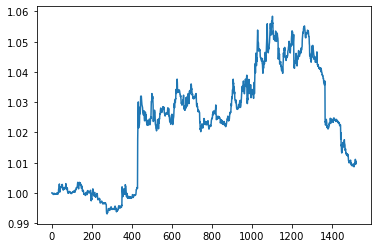

In [12]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot();

In [13]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  TSLA
calculating KPIs for  AMD


In [14]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.698268,-3.305102,0.096328
AAPL,0.317569,0.936598,0.056218
FB,0.964144,3.210510,0.054065
AMZN,0.563345,2.029892,0.065809
INTC,-0.216665,-0.792923,0.063251
CSCO,-0.066375,-0.472655,0.066620
VZ,0.178423,1.122123,0.033283
IBM,0.717634,4.399186,0.042200
TSLA,-0.015905,-0.056014,0.211862
AMD,1.151844,2.748233,0.079295


In [15]:
ohlc_renko['AMD']

,Open,High,Low,Close,Volume,TR,ATR,roll_max_cp,roll_min_cp,roll_max_vol,ret,Date,bar_num,obv,obv_slope
0,93.670,93.7998,93.6300,93.76,217157.0,0.1698,0.255200,94.22,93.230,1104033.0,0.0,2021-02-12 12:50:00,1.0,0.0,0.000000
1,93.765,93.7800,93.4150,93.42,403068.0,0.3650,0.261700,94.22,93.230,1104033.0,0.0,2021-02-12 12:55:00,1.0,-403068.0,0.000000
2,93.420,93.6600,93.3900,93.63,287031.0,0.2700,0.264135,94.22,93.230,1104033.0,0.0,2021-02-12 13:00:00,1.0,-116037.0,0.000000
3,93.630,93.8301,93.5801,93.75,270161.0,0.2500,0.256135,94.22,93.230,1104033.0,0.0,2021-02-12 13:05:00,1.0,154124.0,0.000000
4,93.750,93.8080,93.5400,93.60,210059.0,0.2680,0.262035,94.22,93.230,1104033.0,0.0,2021-02-12 13:10:00,1.0,-55935.0,17.728567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,81.010,81.1900,80.9706,81.13,402398.0,0.2194,0.164765,81.19,80.645,402398.0,0.0,2021-03-12 15:40:00,1.0,-28071278.0,38.691916
1517,81.120,81.1200,80.9100,80.99,453937.0,0.2200,0.166765,81.19,80.645,453937.0,0.0,2021-03-12 15:45:00,1.0,-28525215.0,18.563546
1518,80.990,81.0500,80.9000,80.90,422412.0,0.1500,0.167770,81.19,80.645,453937.0,0.0,2021-03-12 15:50:00,1.0,-28947627.0,-14.234921
1519,80.900,80.9700,80.8150,80.86,614723.0,0.1550,0.168515,81.19,80.645,614723.0,0.0,2021-03-12 15:55:00,1.0,-29562350.0,-39.324164
